## 1. Frame the problem
#### - Given data of several hundred homes for sale in Columbus, Ohio, predict what the price of a house will be depending on different values given for different attributes that the house may have. Ex. approximately how much will a 3 bedroom 2 bathroom 1 garage 2000sqft house cost?
## 2. Get the data
#### - The collected data must have the following attributes: price, year built, bedroom count, bathroom count, and square feet. After constructing a web scraper for the website "www.bexrealty.com", I scraped approximately 1.8k rows of data having to do with homes for sale in Columbus, Ohio. The collected data includes all required attributes plus an address, pool count, and garage count. The scraped data is in the "columbus-ohio-homes-for-sale" input dataset for this notebook.
#### - The code for the scraper as well as the collected data (both raw and cleaned) can be found at https://github.com/victorbjafet/bexRealtyScrape
#### - Code below simply loads data and one hot encodes (also has a data searcher)


In [19]:
#run this cell to load the dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


dataframe = pd.read_json('/kaggle/input/columbus-ohio-homes-for-sale/bexrealty_scrape_data_columbus_ohio_clean.json', orient ='split') #reads in data from json
#columns: Address, Price, Bedrooms, Bathrooms, Garages, Pool, Year, Area

#all modifications to data must go under here

#turns out there are some "Year" values that are 2024 or 9999, so use this to get rid of those
indexes = dataframe[dataframe['Year'].gt(2023)].index.values #makes a new dataframe that contains only the rows with years greater than 2023, then gets all indexes in the dataframe (.index), then turns the indexes into a numpy list (.values)
dataframe = dataframe.drop(indexes) #drops all rows with wrong years

#turns out there are some MORE messed up "Year" values, this time in the other direction (so like 0)
indexes = dataframe[dataframe['Year'].lt(1776)].index.values #makes a new dataframe that contains only the rows with years greater than 2023, then gets all indexes in the dataframe (.index), then turns the indexes into a numpy list (.values)
dataframe = dataframe.drop(indexes) #drops all rows with wrong years

dataframe = dataframe.drop(columns=["Address"]) #get rid of addresses bc theyre useless anyways lul

print(str(len(dataframe)) + " rows in dataframe")

1823 rows in dataframe


In [20]:
#one hot encoding the pool category
#the four types that exist afaik: none, private spa, private pool, community pool

dataframe = pd.get_dummies(dataframe) #one hot encodes all the pool stuff (makes a column for each of the 4 types of pool)

In [ ]:
pd.set_option('display.max_columns', None) #unrestrict amount of columns printable
pd.set_option('display.max_rows', None)  #unrestrict amount of rows printable
pd.set_option('display.max_colwidth', None)  #unrestrict printable width of columns

#a little page search thing to view the data
x = 1
resultsperpage = 10
while x >= 1:
    print(dataframe[resultsperpage * (x - 1):resultsperpage * (x)])
    x = int(input("Input a page number: "))

## 3. Explore the data

In [ ]:
# scatter_matrix_attributes = ["Price", "Bedrooms", "Bathrooms", "Garages", "Year", "Area"]
# pd.plotting.scatter_matrix(dataframe[scatter_matrix_attributes], figsize=(12, 8))
plt.scatter(dataframe.loc[:,'Price'],dataframe.loc[:,'Area'],s=0.5)
plt.show()
plt.scatter(dataframe.loc[:,'Price'],dataframe.loc[:,'Year'],s=0.5)
plt.show()
plt.scatter(dataframe.loc[:,'Price'],dataframe.loc[:,'Bedrooms'],s=0.5)
plt.show()
plt.scatter(dataframe.loc[:,'Price'],dataframe.loc[:,'Bathrooms'],s=0.5)
plt.show()
plt.scatter(dataframe.loc[:,'Price'],dataframe.loc[:,'Garages'],s=0.5)
plt.show()

#### - Somewhat linear relationship appears between area and price, no other readily apparent relationships
#### - Create a correlation matrix to see trends

In [21]:
corr_matrix = dataframe.corr()
print(corr_matrix["Price"])

Price                  1.000000
Bedrooms               0.264426
Bathrooms              0.568170
Garages                0.426066
Year                   0.166231
Area                   0.718303
Pool_Community Pool    0.033901
Pool_No               -0.108822
Pool_Private Pool      0.107368
Pool_Private Spa       0.082131
Name: Price, dtype: float64


#### - Highest correlation to lowest correlation relative to price: area, bathrooms, garages, bedrooms, year built

## 4. Prepare the data
#### - One-hot encoding was done before step 3 to prepare data for the correlation matrix
#### - Create seperate train and test datasets (70/30)

In [22]:
from sklearn.model_selection import train_test_split


# creating feature variables
dataframe_X = dataframe.drop(columns=['Price']) #get all columns but the price column
dataframe_Y = dataframe['Price'] #get only the price column

X_train, X_test, Y_train, Y_test = train_test_split(dataframe_X, dataframe_Y, test_size=0.3, random_state=104)
# "features (X) and labels (y)" basically input data and expected output data
# "let's say you are building a model to predict the price of a house. The features might include the number of bedrooms, the square footage, and the neighborhood. The label, in this case, would be the price of the house"

## 5. Model the data
#### - Test a couple different models to see which ones gives the best result
#### - Graph their results specifically for area since area is the one with the most correlation and easiest to visualize if it follows the trend

### Linear regression:

Mean Squared Error:  112220.20773121953
Mean Absolute Error:  78163.48924766509


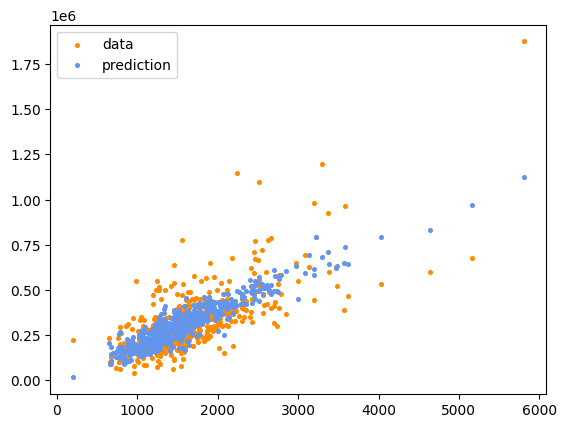

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error #root of the average of the square of all differences
from sklearn.metrics import mean_absolute_error #all differences have equal weight (average without square)

lrg_model = LinearRegression()
lrg_model.fit(X_train,Y_train) #train model on test features (fitting the model)
lrg_price_predictions = lrg_model.predict(X_test) #get the models price predictions

#checks the predictions against the actual values
print('Mean Squared Error: ', mean_squared_error(Y_test, lrg_price_predictions, squared=False)) #~112k
print('Mean Absolute Error: ', mean_absolute_error(Y_test, lrg_price_predictions)) #~78k


plt.scatter(X_test.loc[:,"Area"], Y_test, color='darkorange',
            label='data',s=7)
plt.scatter(X_test.loc[:,"Area"], lrg_price_predictions, color='cornflowerblue',
         label='prediction',s=7)
plt.legend()
plt.show()

### Support vector regression (linear):

Mean Squared Error:  118251.95029219252
Mean Absolute Error:  75326.64481451733


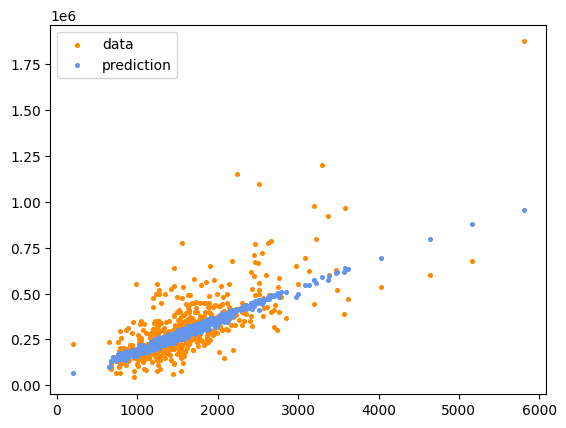

In [24]:
from sklearn.svm import SVR
svrL_model = SVR(kernel='linear')
svrL_model.fit(X_train,Y_train)
svrL_price_predictions = svrL_model.predict(X_test) #get the models price predictions

#checks the predictions against the actual values
print('Mean Squared Error: ', mean_squared_error(Y_test, svrL_price_predictions, squared=False)) #~118k
print('Mean Absolute Error: ', mean_absolute_error(Y_test, svrL_price_predictions)) #~75k


plt.scatter(X_test.loc[:,"Area"], Y_test, color='darkorange',
            label='data',s=7)
plt.scatter(X_test.loc[:,"Area"], svrL_price_predictions, color='cornflowerblue',
         label='prediction',s=7)
plt.legend()
plt.show()

### (FAILED) Support vector regression (polynomial):

In [ ]:
from sklearn.svm import SVR
svrP_model = SVR(kernel='poly')
svrP_model.fit(X_train,Y_train)
svrP_price_predictions = svrP_model.predict(X_test) #get the models price predictions

#checks the predictions against the actual values
print('Mean Squared Error: ', mean_squared_error(Y_test, svrP_price_predictions, squared=False))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, svrP_price_predictions))


plt.scatter(X_test.loc[:,"Area"], Y_test, color='darkorange',
            label='data',s=7)
plt.scatter(X_test.loc[:,"Area"], svrP_price_predictions, color='cornflowerblue',
         label='prediction',s=7)
plt.legend()
plt.show()

### (FAILED) Support vector regression (radial basis function):

In [ ]:
svrR_model = SVR(kernel='rbf')
svrR_model.fit(X_train,Y_train)
svrR_price_predictions = svrR_model.predict(X_test) #get the models price predictions

#checks the predictions against the actual values
print('Mean Squared Error: ', mean_squared_error(Y_test, svrR_price_predictions, squared=False))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, svrR_price_predictions))


plt.scatter(X_test.loc[:,"Area"], Y_test, color='darkorange',
            label='data',s=7)
plt.scatter(X_test.loc[:,"Area"], svrR_price_predictions, color='cornflowerblue',
         label='prediction',s=7)
plt.legend()
plt.show()

### Random forest regressor:

Mean Squared Error:  107536.15756285761
Mean Absolute Error:  69237.17294615094


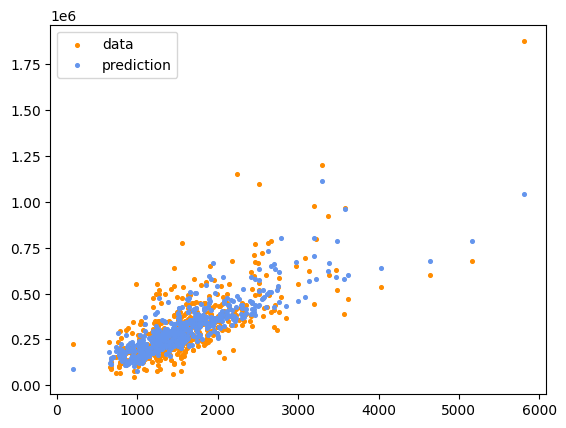

In [25]:
from sklearn.ensemble import RandomForestRegressor
 
rfr_model = RandomForestRegressor(n_estimators=100,random_state=0)
rfr_model.fit(X_train, Y_train)
rfr_price_predictions = rfr_model.predict(X_test) #get the models price predictions

print('Mean Squared Error: ', mean_squared_error(Y_test, rfr_price_predictions, squared=False))
print('Mean Absolute Error: ', mean_absolute_error(Y_test, rfr_price_predictions))


plt.scatter(X_test.loc[:,"Area"], Y_test, color='darkorange',
            label='data',s=7)
plt.scatter(X_test.loc[:,"Area"], rfr_price_predictions, color='cornflowerblue',
         label='prediction',s=7)
plt.legend()
plt.show()

### Polynomial regression:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform()
preg_model = LinearRegression()



# create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df[['RM']])

# fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, df['MEDV'])

# make predictions
y_pred = model.predict(X_poly)

# calculate the RMSE
rmse = mean_squared_error(df['MEDV'], y_pred, squared=False)
print('RMSE:', rmse)

## 6. Fine-tune the models
#### - Did not manage to use hyperparameters, gridsearch was not functioning
#### - Only linear regression and svr with a linear kernel worked within reason, so plot data and analyze further which one was more accurate

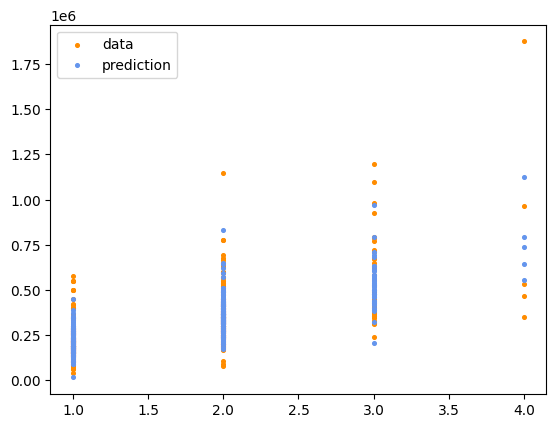

In [26]:
#linear regression
plt.scatter(X_test.loc[:,"Bathrooms"], Y_test, color='darkorange',
            label='data',s=7)
plt.scatter(X_test.loc[:,"Bathrooms"], lrg_price_predictions, color='cornflowerblue',
         label='prediction',s=7)
plt.legend()
plt.show()

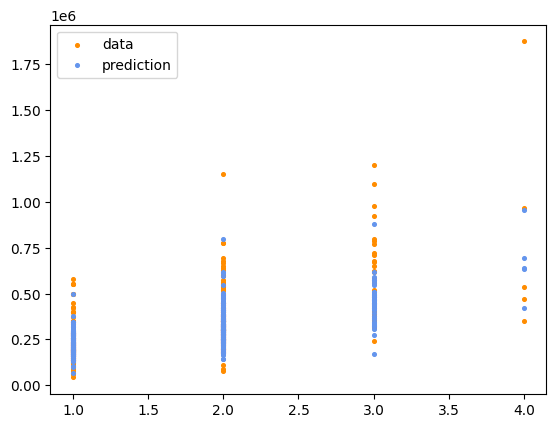

In [27]:
#svr linear
plt.scatter(X_test.loc[:,"Bathrooms"], Y_test, color='darkorange',
            label='data',s=7)
plt.scatter(X_test.loc[:,"Bathrooms"], svrL_price_predictions, color='cornflowerblue',
         label='prediction',s=7)
plt.legend()
plt.show()

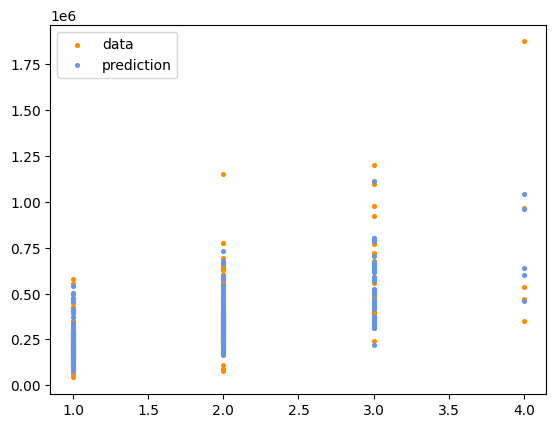

In [28]:
#rfr
plt.scatter(X_test.loc[:,"Bathrooms"], Y_test, color='darkorange',
            label='data',s=7)
plt.scatter(X_test.loc[:,"Bathrooms"], rfr_price_predictions, color='cornflowerblue',
         label='prediction',s=7)
plt.legend()
plt.show()

#### - Choose the best model: in this case, by observing the plotted data and the rmse/mae, random forest regressor did better so it gets chosen as the final model to be saved and exported

## 7. Present the solution
#### -  First, I imported my data and cleaned up some arbitrary values that shouldn't exist
#### - Then, I visualized the data to see what correlated most with the price (which ended up being area)
#### -  Then, I split the data into a test and train set, and then tried fitting different models to see which would give the best results
#### - Then, I decided on the model that was best at predicting the data based on rmse/mae and the predictions vs actual values plotted against area (since it had the highest correlation)
#### - Finally, deploy the chosen model to a file for usage elsewhere
### THE CHOSEN MODEL WAS RANDOM FOREST REGRESSOR

## 8. Launch the ML system
#### Pickle the model to be loaded whenever needed

In [29]:
#Save the model
import pickle

pickle.dump(rfr_model, open('/kaggle/working/lrg_model.pkl', 'wb'))

#### Test loading the module from pickled file

## RUN THE CELL BELOW AND INPUT BEDROOM COUNT, BATHROOM COUNT, GARAGE COUNT, YEAR BUILT, AREA IN SQFT, AND POOL TYPE

In [32]:
### Load and run the model
import pickle
lrg_model_loaded = pickle.load(open('/kaggle/working/lrg_model.pkl', 'rb'))

def predict(Bedrooms: int = 3, Bathrooms: int = 3, Garages: int = 1, Year: int = 1963, Area: int = 2167, Pool: str = "Private_Pool"):
    if Pool == "Community Pool":
        Community_Pool = True
        No_Pool = False
        Private_Pool = False
        Spa_Pool = False
    elif Pool == "Private Pool":
        Community_Pool = False
        No_Pool = False
        Private_Pool = True
        Spa_Pool = False
    elif Pool == "Private Spa":
        Community_Pool = False
        No_Pool = False
        Private_Pool = False
        Spa_Pool = True
    else:
        Community_Pool = False
        No_Pool = True
        Private_Pool = False
        Spa_Pool = False
        
    params = [[Bedrooms, Bathrooms, Garages, Year, Area, Community_Pool, No_Pool, Private_Pool, Spa_Pool]]
    predict_df = pd.DataFrame(params, columns=['Bedrooms', 'Bathrooms', 'Garages', 'Year', 'Area', 'Pool_Community Pool', 'Pool_No', 'Pool_Private Pool', 'Pool_Private Spa'])
    predicted_value = lrg_model_loaded.predict(predict_df)
    return(predicted_value[0])

bed = int(input("Bedroom count: "))
bath = int(input("Bathroom count:"))
garage = int(input("Garage count: "))
year_built = int(input("Year built: "))
area_sqft = int(input("Area (in SQFT): "))
pool_type = input("Pool type (Community Pool, No, Private Pool, Private Spa): ")

             
ret = predict(bed, bath, garage, year_built, area_sqft, pool_type)
# ret = predict()
print("The predicted value is: $" + str(ret.round(2)))

Bedroom count:  3
Bathroom count: 3
Garage count:  1
Year built:  1963
Area (in SQFT):  2167
Pool type (Community Pool, No, Private Pool, Private Spa):  No


The predicted value is: $416615.76
